<font size="10">Assignment 3</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# class objects, see the file "environment.py"
from environment import Environment_1 as ENV_1
from environment import Environment_2 as ENV_2

0. Relavent functions

In [2]:
def argmax_random(input_array):
    """ 
    Randomely select the maximum value (break the ties arbitrarily)
    Input:
        input_array (1d array) - array needed to be found the maximum value
    Output:
        index for the maximum value, if multiple, randomely select one
    """
    
    return np.random.choice(np.flatnonzero(input_array == np.max(input_array)))


def select_action(q, eps, env):
    """ 
    ϵ-greedy policy
    Input:
        q (1d array) - action value function for a state
        epsilon (float) - Algorithm parameter: small ϵ > 0
        env (class) - gridworld environment with the following parameters:
            env.n_action (int) - number of possible actions
    Output:
        selected action (int)
    """
    
    if np.random.rand() > eps:  # ϵ-greedy
        return argmax_random(q)  # randomely select the largest action
    else:
        return np.random.choice([i for i in range(env.n_action)])  # randomely select


def find_policy(gamma, V, env):
    """ 
    Find the optimal policy under the current value function
    Input:
        gamma (float) - reward discount factor
        V (1d array) - Input value function
        env (class) - gridworld environment with the following parameters:
            env.n_state (int)    - number of states
            env.n_action (int)   - number of actions
            env.model (4d array) - (n_state) by (n_action) by (n) by (3) array, for state s and action a,
                                   there are n possibilities, each row is composed of (p, s_, r)
                                    p  - transition probability from (s,a) to (s_)   ### sum of the n possibilities -- n p equals 1
                                    s_ - next state
                                    r  - reward of the transition from (s,a) to (s_)
    Output:
        pol (2d array) - Calculated optimum policy under the input value function
                         the first dimension is for states, the second dimension is for possible multiple choices
    """

    pol = [[0] for _ in range(env.n_state)]  # initialize a deterministic policy

    for s in range(env.n_state):  # sweep all the states in the state space
        temp1 = []
        for a in range(env.n_action):  # sweep all the actions in the action space
            temp2 = 0
            for p, s_, r, _ in env.model[s][a]:  # sweep all the possibilities in model
                temp2 += p * (r + gamma * V[s_])
            temp1.append(temp2)
                
        pol[s] = (np.unique(np.argwhere(temp1 == np.max(temp1)))).tolist()  # find the optimal policy under the current value function
        
    return pol


def print_policy(policy, env):
    """ 
    Print the policy for visualization
    Input:
        policy (1d array) - a deterministic policy
        env (class) - gridworld environment with the following parameters:
            env.n_state (int) - number of states
            env.action_text (1d array) - contain the unicode of the arrows for visualization
                                             left ←    down ↓    right →   up ↑
                                          ['\u2190', '\u2193', '\u2192', '\u2191']
    Output:
        policy_visual (1d array) - visualized policy, with arrows pointing to the moving direction
    """

    policy_visual = ['' for _ in range(env.n_state)]

    for s in range(env.n_state):
        lenth = len(policy[s])
        if lenth == 4:  # if 4 directions are all available
            policy_visual[s] += 'o'  # 'o' means 4 directions are all available
        else:
            for a in range(lenth):
                policy_visual[s] += env.action_text[policy[s][a]]  # put all possibilities

    return policy_visual


def plot_trajectory(policy, env):
    """ 
    Print the policy for visualization
    Input:
        policy (1d array) - a deterministic policy
        env (class) - gridworld environment with the following parameters:
            env.n_state (int) - number of states
            env.state_0 (int) - start state, the blue grid
            env.action_text (1d array) - contain the unicode of the arrows for visualization
                                             left ←    down ↓    right →   up ↑
                                          ['\u2190', '\u2193', '\u2192', '\u2191']
    Output:
        trajectory_visual (1d array) - visualized trajectory, with arrows pointing to the moving direction
    """

    trajectory_visual = [' ' for _ in range(env.n_state)]
    s = env.state_0
    for _ in range(100):  # in case the policy is loopy
        trajectory_visual[s] = env.action_text[policy[s][0]]  # if has multiple choices, select the first one
        _, s_, _, t = env.model[s][policy[s][0]][0]  # get new state
        s = s_

        if t:  # if next state is the terminal state
            trajectory_visual[s] = 'x'
            break

    return trajectory_visual

<font size="6">Part 1</font>

1. Use Sarsa algorithm

In [13]:
def Sarsa(max_ep, gamma, epsilon, alpha, env):
    """ 
    Sarsa algorithm
    Input:
        max_ep (int) - maximum number of episodes
        gamma (float) - reward discount factor
        epsilon (float) - Algorithm parameter: small ϵ > 0
        alpha (float) - learning rate
        env (class) - gridworld environment with the following parameters:
            env.n_state (int)    - number of states
            env.n_action (int)   - number of actions
            env.state_0 (int)    - start state, the blue grid
            env.model (4d array) - (n_state) by (n_action) by (n) by (4) array, for state s and action a,
                                    there are n possibilities, each row is composed of (p, s_, r, t)
                                    p  - transition probability from (s,a) to (s_)   ### sum of the n p equals 1
                                    s_ - next state
                                    r  - reward of the transition from (s,a) to (s_)
                                    t  - terminal information, a bool value, True/False
    Output:
        Q_all (2d array) - Estimated Q function, for each state and each action
        Q_opt (1d array) - Estimated optimal Q function
        policy_opt (2d array) - Calculated optimum policy, the first dimension is for states, the second dimension is for possible multiple choices
        reward_trace (1d array) - recorded sum of reward for each episode
    """

    # Initialize
    policy_opt = [[0] for _ in range(env.n_state)]  # initialize a deterministic policy
    Q_all = [[0 for _ in range(env.n_action)] for _ in range(env.n_state)]  # Q function
    Q_opt = [0 for _ in range(env.n_state)]
    reward_trace = [0 for _ in range(max_ep)]

    # for each episode
    for ep in range(max_ep):
        # initialize
        s = env.state_0
        a = select_action(Q_all[s], epsilon, env)
        r_sum = 0

        while 1:
            _, s_, r, t = env.model[s][a][0]  # get new state and reward
            a_ = select_action(Q_all[s_], epsilon, env)  # select new action based on new state
            Q_all[s][a] += alpha * (r + gamma * Q_all[s_][a_] - Q_all[s][a])  # update q function
            s, a = s_, a_  # update state and action
            r_sum += r  # update reward sum
            if t:  # if next state is the terminal state
                break

        reward_trace[ep] = r_sum  # record reward sum

    for s in range(env.n_state):  # sweep all the states in the state space
        policy_opt[s] = (np.unique(np.argwhere(Q_all[s] == np.max(Q_all[s])))).tolist()  # find the optimal policy under the Q function

    Q_opt = np.max(Q_all, axis=1)  # find the optimal Q function

    return Q_all, Q_opt, policy_opt, reward_trace


2. Use Q-learning algorithm

In [14]:
def Q_learning(max_ep, gamma, epsilon, alpha, env):
    """ 
    Q-learning algorithm
    Input:
        max_ep (int) - maximum number of episodes
        gamma (float) - reward discount factor
        epsilon (float) - Algorithm parameter: small ϵ > 0
        alpha (float) - learning rate
        env (class) - gridworld environment with the following parameters:
            env.n_state (int)    - number of states
            env.n_action (int)   - number of actions
            env.state_0 (int)    - start state, the blue grid
            env.model (4d array) - (n_state) by (n_action) by (n) by (4) array, for state s and action a,
                                    there are n possibilities, each row is composed of (p, s_, r, t)
                                    p  - transition probability from (s,a) to (s_)   ### sum of the n p equals 1
                                    s_ - next state
                                    r  - reward of the transition from (s,a) to (s_)
                                    t  - terminal information, a bool value, True/False
    Output:
        Q_all (2d array) - Estimated Q function, for each state and each action
        Q_opt (1d array) - Estimated optimal Q function
        policy_opt (2d array) - Calculated optimum policy, the first dimension is for states, the second dimension is for possible multiple choices
        reward_trace (1d array) - recorded sum of reward for each episode
    """

    # Initialize
    policy_opt = [[0] for _ in range(env.n_state)]  # initialize a deterministic policy
    Q_all = [[0 for _ in range(env.n_action)] for _ in range(env.n_state)]  # Q function
    Q_opt = [0 for _ in range(env.n_state)]
    reward_trace = [0 for _ in range(max_ep)]

    # for each episode
    for ep in range(max_ep):
        # initialize
        s = env.state_0
        r_sum = 0

        while 1:
            a = select_action(Q_all[s], epsilon, env)  # select the action
            _, s_, r, t = env.model[s][a][0]  # get new state and reward
            Q_max = np.max(Q_all[s_])  # find the maximum q value
            Q_all[s][a] += alpha * (r + gamma * Q_max - Q_all[s][a])  # update q function
            s = s_  # update state
            r_sum += r  # update reward sum
            if t:  # if next state is the terminal state
                break
        
        reward_trace[ep] = r_sum  # record reward sum

    for s in range(env.n_state):  # sweep all the states in the state space
        policy_opt[s] = (np.unique(np.argwhere(Q_all[s] == np.max(Q_all[s])))).tolist()  # find the optimal policy under the Q function

    Q_opt = np.max(Q_all, axis=1)  # find the optimal Q function

    return Q_all, Q_opt, policy_opt, reward_trace

3. Results

In [15]:
# Initialize the environment, set up parameters
max_ep = 10000
gam = 0.99  # discount factor
eps = 0.2  # epsilon, Algorithm parameter: small ϵ > 0
alp = 0.5  # learning rate
Env = ENV_1()

# Find the optimal policy
Q_1, Q_opt_1, pol_opt_1, reward_plot_1 = Sarsa(max_ep, gam, eps, alp, Env)
Q_2, Q_opt_2, pol_opt_2, reward_plot_2 = Q_learning(max_ep, gam, eps, alp, Env)

Sarsa algorithm:
[['o' '←' '→' '→' 'o']
 ['↑' '↑' '↑' '↑' '↑']
 ['o' 'o' '↑' 'o' 'o']
 ['→' '→' '↑' '←' '←']
 ['↑' '→' '↑' '↑' '←']] 

Q-learning algorithm:
[['o' '←' '←→' '→' 'o']
 ['↑' '←↑' '←→↑' '→↑' '↑']
 ['o' 'o' '↑' 'o' 'o']
 ['→' '→' '↑' '←' '←']
 ['→↑' '→↑' '↑' '←↑' '←']] 

Sarsa algorithm trajectory:
[[' ' ' ' '→' '→' 'x']
 [' ' ' ' '↑' ' ' ' ']
 [' ' ' ' '↑' ' ' ' ']
 ['→' '→' '↑' ' ' ' ']
 ['↑' ' ' ' ' ' ' ' ']] 

Q-learning algorithm trajectory:
[['x' ' ' ' ' ' ' ' ']
 ['↑' '←' '←' ' ' ' ']
 [' ' ' ' '↑' ' ' ' ']
 [' ' ' ' '↑' ' ' ' ']
 ['→' '→' '↑' ' ' ' ']] 



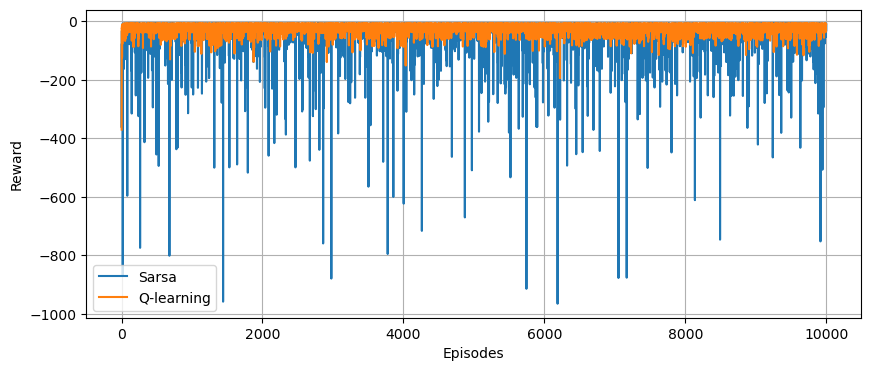

In [16]:
# Print the results
print('Sarsa algorithm:')
# print(np.array(Q_1), '\n')
print((np.array(print_policy(pol_opt_1, Env))).reshape([5, -1]), '\n')

print('Q-learning algorithm:')
# print(np.array(Q_2), '\n')
print((np.array(print_policy(pol_opt_2, Env))).reshape([5, -1]), '\n')

print('Sarsa algorithm trajectory:')
print((np.array(plot_trajectory(pol_opt_1, Env))).reshape([5, -1]), '\n')

print('Q-learning algorithm trajectory:')
print((np.array(plot_trajectory(pol_opt_2, Env))).reshape([5, -1]), '\n')

fig1 = plt.figure(figsize=(10, 4))
plt.plot(range(1,max_ep+1), reward_plot_1, label = "Sarsa")
plt.plot(range(1,max_ep+1), reward_plot_2, label = "Q-learning")
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend(loc='lower left')
plt.grid()
plt.show()

<font size="6">Part 2</font>

0. Affine function approximation

In [3]:
def Affine(state, env):
    """
    Affine function approximation
    Input:
        state (int) - state number
        env (class) - gridworld environment with the following parameters:
            env.n_state (int) - number of states
    Output:
        fv (1d array) - encoded feature vector
    """
    
    fv = np.zeros(env.n_state)  # initialize the feature vector
    fv[state] = 1  # use one-hot encoding for the input state
    
    return fv

1. Use gradient Monte Carlo method

In [4]:
def Gradient_Monte_Carlo(max_ep, alpha, gamma, policy, env):
    """
    Gradient Monte Carlo method
    Input:
        max_ep (int) - maximum number of episodes
        alpha (float) - learning rate
        gamma (float) - reward discount factor
        policy (2d array) - input policy
        env (class) - gridworld environment with the following parameters:
            env.n_state (int) - number of states
            env.n_action (int)   - number of actions
            env.model (4d array) - (n_state) by (n_action) by (n) by (4) array, for state s and action a,
                                    there are n possibilities, each row is composed of (p, s_, r, t)
                                    p  - transition probability from (s,a) to (s_)   ### sum of the n p equals 1
                                    s_ - next state
                                    r  - reward of the transition from (s,a) to (s_)
                                    t  - terminal information, a bool value, True/False
    Output:
        VF (1d array) - Calculated value function
        policy_opt (2d array) - Calculated optimum policy
    """
    w = np.zeros(env.n_state)

    for ep in range(max_ep):
        s = env.state_0
        Traces = []  # initialize the moving trajectory

        # Generate an episode
        while 1:
            a = np.random.choice(np.arange(env.n_action),p=policy[s])  # choose the action under the equiprobable policy
            _, s_, r, t = env.model[s][a][0]  # get new state and reward

            Traces.append([s, a, r])  # generate the moving trajectory

            s = s_  # update state
            
            if t:  # if terminal, break
                break
        
        G = 0
        for t, trace in enumerate(Traces[::-1]):  # Start from the end of the trajectory
            G = gamma * G + trace[2]  # update G
            x = Affine(trace[0], env)  # feature vector based on current state
            w += alpha * (G - np.dot(w, x)) * x  # update weight, np.dot(w, x) is v_hat, and x is simply the gradient of v_hat
    
    VF = np.round(np.array(w),3)  # round the value function (weight)
    policy_opt = find_policy(gamma, np.array(w), env)  # find the optimal policy based on current value function
    
    return VF, policy_opt

2. Use semi-gradient TD(0) method with an affine function approximation

In [5]:
def Semi_gradient_TD_0(max_ep, alpha, gamma, policy, env):
    """
    Semi-gradient TD(0) method
    Input:
        max_ep (int) - maximum number of episodes
        alpha (float) - learning rate
        gamma (float) - reward discount factor
        policy (2d array) - input policy
        env (class) - gridworld environment with the following parameters:
            env.n_state (int) - number of states
            env.n_action (int)   - number of actions
            env.model (4d array) - (n_state) by (n_action) by (n) by (4) array, for state s and action a,
                                    there are n possibilities, each row is composed of (p, s_, r, t)
                                    p  - transition probability from (s,a) to (s_)   ### sum of the n p equals 1
                                    s_ - next state
                                    r  - reward of the transition from (s,a) to (s_)
                                    t  - terminal information, a bool value, True/False
    Output:
        VF (1d array) - Calculated value function
        policy_opt (2d array) - Calculated optimum policy
    """
    w = np.zeros(env.n_state)

    for ep in range(max_ep):
        s = env.state_0

        # In an episode
        while 1:
            a = np.random.choice(np.arange(env.n_action),p=policy[s])  # choose the action under the equiprobable policy
            _, s_, r, t = env.model[s][a][0]  # get new state and reward

            x = Affine(s, env)  # feature vector based on current state
            x_ = Affine(s_, env)  # feature vector based on next state
            w += alpha * (r + gamma * np.dot(w, x_) - np.dot(w, x)) * x  # update weight

            s = s_  # update state
            if t:  # if terminal, break
                break
    
    VF = np.round(np.array(w),3)  # round the value function (weight)
    policy_opt = find_policy(gamma, np.array(w), env)  # find the optimal policy based on current value function
    
    return VF, policy_opt

3. Compute the exact value function

In [6]:
def Bellman_equa(gamma, policy, env):
    """ 
    Bellman equations
    Input:
        gamma (float) - reward discount factor
        policy (2d array) - input policy
        env (class) - gridworld environment with the following parameters:
            env.n_state (int) - number of states
            env.n_action (int)   - number of actions
            env.model (4d array) - (n_state) by (n_action) by (n) by (4) array, for state s and action a,
                                    there are n possibilities, each row is composed of (p, s_, r, t)
                                    p  - transition probability from (s,a) to (s_)   ### sum of the n p equals 1
                                    s_ - next state
                                    r  - reward of the transition from (s,a) to (s_)
                                    t  - terminal information, a bool value, True/False
    Output:
        VF (1d array) - Calculated value function
        policy_opt (2d array) - Calculated optimum policy
    """
    
    # Initialize the system of linear equations
    # Calculate the value function by (A * VF = b)
    A = np.zeros([env.n_state, env.n_state])
    b = np.zeros(env.n_state)

    for s in range(env.n_state):  # sweep all the states in the state space
        A[s,s] = 1  # VF[s] = sum(policy[s,a] * p * (r + gamma * VF[s_])), hence the coefficient for VF[s] is 1
        for a in range(env.n_action):  # sweep all the actions in the action space
            for p, s_, r, _ in env.model[s][a]:  # sweep all the possibilities in model
                A[s,s_] -= policy[s,a] * p * gamma  # put the coefficients of VF[s_] to the left of the equation, hence minus
                b[s] += policy[s,a] * p * r  # keep the constants to the right of the equation

    # VF = A' * b, value function equals the procuct of inverse A and b
    if np.linalg.det(A) == 0: raise ValueError("A is not invertible !!!!!!!!!!")
    A_ = np.linalg.inv(A)
    VF = np.dot(A_, b)

    VF = np.round(VF,3)
    policy_opt = find_policy(gamma, VF, env)  # find the optimal policy based on current value function
    
    return VF, policy_opt

3. Results

In [17]:
# Initialize the environment, set up parameters
max_ep = 10000
gam = 0.99  # discount factor
alp = 0.01  # learning rate
Env = ENV_2()
pol = np.ones([Env.n_state, Env.n_action]) / Env.n_action  # the equalprobable policy

# Find the optimal policy
V_3, pol_opt_3 = Gradient_Monte_Carlo(max_ep, alp, gam, pol, Env)
V_4, pol_opt_4 = Semi_gradient_TD_0(max_ep, alp, gam, pol, Env)
V_5, pol_opt_5 = Bellman_equa(gam, pol, Env)

In [18]:
# Print the results
print('Gradient Monte Carlo method:')
print(V_3.reshape([7, -1]), '\n')
print((np.array(print_policy(pol_opt_3, Env))).reshape([7, -1]), '\n')

print('Semi-gradient TD(0) method:')
print(V_4.reshape([7, -1]), '\n')
print((np.array(print_policy(pol_opt_4, Env))).reshape([7, -1]), '\n')

print('Exact value function:')
print(V_5.reshape([7, -1]), '\n')
print((np.array(print_policy(pol_opt_5, Env))).reshape([7, -1]), '\n')

Gradient Monte Carlo method:
[[ 0.109  0.112  0.234  0.3    0.45   0.618  0.   ]
 [-0.008  0.066  0.118  0.202  0.297  0.474  0.568]
 [-0.058 -0.012  0.022  0.127  0.234  0.44   0.432]
 [-0.258 -0.181 -0.068  0.068  0.164  0.317  0.306]
 [-0.4   -0.385 -0.178 -0.062  0.047  0.177  0.177]
 [-0.64  -0.501 -0.264 -0.156 -0.086  0.019  0.033]
 [ 0.    -0.623 -0.327 -0.221 -0.196 -0.166 -0.091]] 

[['→' '→' '→' '→' '→' '→' 'o']
 ['↑' '→' '↑' '↑' '→' '↑' '↑']
 ['↑' '↑' '→' '→' '→' '↑' '↑']
 ['↑' '↑' '→' '→' '→' '↑' '↑']
 ['↑' '→' '→' '↑' '→' '↑' '↑']
 ['↑' '→' '→' '↑' '↑' '↑' '↑']
 ['o' '→' '→' '↑' '↑' '↑' '↑']] 

Semi-gradient TD(0) method:
[[ 0.001  0.024  0.093  0.21   0.371  0.6    0.   ]
 [-0.03  -0.003  0.056  0.143  0.282  0.428  0.561]
 [-0.088 -0.062 -0.     0.081  0.196  0.266  0.364]
 [-0.2   -0.145 -0.077  0.017  0.093  0.165  0.198]
 [-0.34  -0.263 -0.157 -0.065  0.011  0.064  0.09 ]
 [-0.581 -0.437 -0.271 -0.134 -0.049  0.001  0.036]
 [ 0.    -0.603 -0.362 -0.195 -0.084 -0.023 

In [19]:
diff_Gradient_Monte_Carlo = ((V_3-V_5)**2).mean()
diff_Semi_gradient_TD_0 = ((V_4-V_5)**2).mean()

print('MSE between Gradient Monte Carlo method and the exact value function:')
print(diff_Gradient_Monte_Carlo, '\n')

print('MSE between Semi-gradient TD(0) method and the exact value function:')
print(diff_Semi_gradient_TD_0, '\n')

MSE between Gradient Monte Carlo method and the exact value function:
0.005529755102040816 

MSE between Semi-gradient TD(0) method and the exact value function:
0.00012297959183673465 

